In [98]:
import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
from tqdm import tqdm

# Data preprocessing

In [2]:
# load data
df = pd.DataFrame()

for path in glob.glob("data/*.RData"):
    _df = pyreadr.read_r(path)
    k = list(_df.keys())[0]
    _df =  _df[k]
    df = pd.concat([df, _df])

df = df.reset_index()
df

,index,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0,0.0,1.0,1,0.25171,3672.4,4466.3,9.5122,27.057,42.473,...,54.494,24.527,59.710,22.357,40.149,40.074,47.955,47.300,42.100,15.345
1,1,0.0,1.0,2,0.25234,3642.2,4568.7,9.4145,26.999,42.586,...,53.269,24.465,60.466,22.413,39.956,36.651,45.038,47.502,40.553,16.063
2,2,0.0,1.0,3,0.24840,3643.1,4507.5,9.2901,26.927,42.278,...,54.000,24.860,60.642,22.199,40.074,41.868,44.553,47.479,41.341,20.452
3,3,0.0,1.0,4,0.25153,3628.3,4519.3,9.3347,26.999,42.330,...,53.860,24.553,61.908,21.981,40.141,40.066,48.048,47.440,40.780,17.123
4,4,0.0,1.0,5,0.21763,3655.8,4571.0,9.3087,26.901,42.402,...,53.307,21.775,61.891,22.412,37.696,38.295,44.678,47.530,41.089,18.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15329995,4999995,20.0,500.0,496,0.23419,3655.3,4461.7,9.3448,27.008,42.481,...,53.670,23.350,61.061,20.719,40.999,38.653,47.386,47.528,40.212,17.659
15329996,4999996,20.0,500.0,497,0.26704,3647.4,4540.2,9.3546,27.034,42.671,...,54.650,26.362,60.020,20.263,41.579,33.624,47.536,47.647,41.199,18.741
15329997,4999997,20.0,500.0,498,0.26543,3630.3,4571.6,9.4089,27.129,42.470,...,54.274,26.521,59.824,20.189,41.505,40.967,52.437,47.802,41.302,23.199
15329998,4999998,20.0,500.0,499,0.27671,3655.7,4498.9,9.3781,27.353,42.281,...,53.506,26.781,62.818,20.453,40.208,40.957,47.628,48.086,40.510,15.932


In [3]:
# preprocess data
df["faultNumber"] = df["faultNumber"].astype(int)
df = df.drop(["simulationRun", "sample", "index"], axis=1)

In [4]:
# remove 3, 9 and 15
mask = ~df["faultNumber"].isin([3, 9, 15])

In [5]:
df = df[mask]
df["faultNumber"].unique()

array([ 0,  1,  2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 16, 17, 18, 19,
       20])

In [6]:
# features
X = df.loc[:, df.columns != "faultNumber"].values
# labels
y = df["faultNumber"].values

X.shape, y.shape

((13140000, 52), (13140000,))

In [7]:
df.columns[df.columns != "faultNumber"]

Index(['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6',
       'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12',
       'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18',
       'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24',
       'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30',
       'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36',
       'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 'xmv_1',
       'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9',
       'xmv_10', 'xmv_11'],
      dtype='object')

### Scaler
The recommended way (see 'Elements of Statistical Learning', chapter 'The Wrong and Right Way to Do Cross-validation') is to calculate the **mean** and the **standard deviation** of the values in the **training set** and then **apply them for standardizing both the training and testing sets**.

The idea behind this is to preven**t data leakage** from the testing to the training set because the aim of model validation is to subject the testing data to the same conditions as the data used for the model training.

In [8]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_X.shape

(13140000, 52)

In [9]:
scaled_df = pd.DataFrame(scaled_X, columns=df.columns[df.columns != "faultNumber"])
scaled_df.head(3)

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,-0.048403,0.172463,-0.370896,0.317190,0.674038,0.295625,-0.255480,-0.073291,0.133912,-0.109065,...,-0.023099,-0.276875,-0.466629,-0.071480,0.052982,0.688629,0.655752,-0.156733,-0.000211,-0.485108
1,-0.044249,-0.510475,0.523796,0.069667,0.422894,0.638373,-0.260356,0.202214,-0.273659,-0.090802,...,-0.191197,-0.279855,-0.380834,-0.067129,0.039000,-0.476264,-0.587066,-0.145792,-0.130463,-0.397765
2,-0.070227,-0.490122,-0.010922,-0.245500,0.111128,-0.295842,-0.281081,-0.227164,-0.273659,-0.102173,...,-0.090887,-0.260867,-0.360861,-0.083757,0.047548,1.299152,-0.793705,-0.147038,-0.064116,0.136149


In [10]:
scaled_df.describe()

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
count,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,...,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07,1.314000e+07
mean,-7.793533e-16,-7.748663e-14,2.111692e-15,1.472170e-14,-1.295664e-13,1.536178e-13,-2.976028e-14,4.304707e-14,1.713684e-12,-4.899861e-15,...,-1.218418e-14,-8.172694e-16,1.650911e-14,-1.045025e-15,4.457157e-15,-1.731363e-14,6.869924e-15,1.264669e-15,3.776892e-15,3.278473e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.740879e+00,-8.058969e+00,-8.458078e+00,-6.959772e+00,-6.726066e+00,-8.248797e+00,-3.812835e+00,-1.005158e+01,-1.073464e+01,-3.762003e+00,...,-6.492572e+00,-1.473142e+00,-7.243393e+00,-1.816945e+00,-2.855521e+00,-5.364186e+00,-5.558764e+00,-2.755571e+00,-3.588298e+00,-2.352624e+00
25%,-2.778506e-01,-6.325895e-01,-3.394423e-01,-3.047835e-01,-5.990048e-01,-5.718597e-01,-3.505700e-01,-3.180223e-01,-2.736590e-01,-2.699887e-01,...,-1.584009e-01,-3.899846e-01,-3.967221e-01,-1.437417e-01,-8.705024e-02,-6.947449e-01,-6.641828e-01,-2.670049e-01,-1.289475e-01,-2.688179e-01
50%,-5.512817e-02,-2.201628e-02,3.930875e-03,-7.474204e-02,-5.783974e-03,-7.442083e-02,-2.554797e-01,6.812522e-02,-1.945255e-03,-1.143486e-01,...,-9.376873e-02,-2.452922e-01,-2.602000e-01,-8.973954e-02,3.639215e-02,2.637937e-02,-4.895167e-02,-1.139454e-01,-7.539861e-02,-1.264895e-01
75%,1.561219e-01,5.953411e-01,3.560413e-01,1.917818e-01,6.047572e-01,4.715487e-01,-1.396645e-01,4.220327e-01,2.697684e-01,2.877147e-02,...,-2.748989e-02,-7.411293e-02,-1.013214e-01,-4.265276e-02,1.483161e-01,6.474515e-01,6.757770e-01,9.879972e-02,-1.081993e-02,2.763879e-02
max,5.000698e+00,5.470881e+00,5.828169e+00,7.228061e+00,7.203797e+00,6.907922e+00,3.339668e+00,9.041109e+00,8.285323e+00,5.453893e+00,...,6.221384e+00,3.361250e+00,4.107940e+00,5.970003e+00,4.209672e+00,5.506107e+00,5.879678e+00,2.728975e+00,4.926123e+00,9.814238e+00


In [11]:
def create_samples(X, y, lookback=5):
    x_out = []
    y_out = []
    with tqdm(total=len(X)-lookback-1) as pbar:
        for i in range(len(X)-lookback-1):
            _x = X[i:i+lookback, :]
            _y = y[i+lookback+1]
            x_out.append(_x)
            y_out.append(_y)
            pbar.update(1)

    print("Preparing numpy return. This could take some seconds.")
    return np.array(x_out), np.array(y_out)

In [12]:
_x, _y = create_samples(scaled_df.values, y)
_x.shape, _y.shape

100%|█████████████████████████████████████████████████████████████████| 13139994/13139994 [00:05<00:00, 2314658.67it/s]


Preparing numpy return. This could take some seconds.


((13139994, 5, 52), (13139994,))

[Link](https://datascience.stackexchange.com/questions/63717/how-to-use-standardization-standardscaler-for-train-and-test)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(_x, _y, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [14]:
# Train samples
print("Train:")
print(f"All samples: {X_train.shape[0]}")
print(f"Without anomalies: {X_train[y_train == 0].shape[0]}")
# Test samples
print("Test:")
print(f"All samples: {X_test.shape[0]}")
print(f"Without anomalies: {X_test[y_test == 0].shape[0]}")
# Train samples
print("Validation:")
print(f"All samples: {X_val.shape[0]}")

Train:
All samples: 9197995
Without anomalies: 511426
Test:
All samples: 1971000
Without anomalies: 109288
Validation:
All samples: 1970999


# LSTM VAE

### Encoder

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.0):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )

    def forward(self, X):
        output, (hidden_state, cell_state) = self.lstm(X)
        return hidden_state

### Decoder

In [16]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=False
        )
        # reconstruction
        self.linear_recon = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        output, (hidden_state, cell_state) = self.lstm(X)
        return self.linear_recon(output)

### VAE

In [17]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, num_layers, device, dropout=0.0):
        super(VAE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.latent_size = latent_size
        self.device = device

        self.encoder = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout
        ).to(self.device)

        self.decoder = Decoder(
            input_size=latent_size, # compressed vector size
            hidden_size=hidden_size,
            output_size=input_size, # reconstruction of features at timestep
            num_layers=num_layers,
            dropout=dropout
        ).to(self.device)

        self.z_mean = nn.Linear((self.hidden_size*self.num_layers), self.latent_size).to(self.device)
        self.z_log_var = nn.Linear((self.hidden_size*self.num_layers), self.latent_size).to(self.device)

    def reparametrize(self, z_mu, z_log_var):
        # mu - mean vector
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(self.device)
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def forward(self, X):
        batch_size, seq_len, features_dim = X.shape

        # encode
        # tensor of shape: 1*num_layers, batch_size, hidden_size
        enc_hidden = self.encoder(X)
        enc_hidden = enc_hidden.transpose(0, 1).contiguous().view(batch_size, -1) # (batch_size, hidden_size*num_layers)

        # extract latent variable z (hidden to latent)
        _z_mean = self.z_mean(enc_hidden)
        _z_log_var = self.z_log_var(enc_hidden)
        z = self.reparametrize(_z_mean, _z_log_var) # Shape: batch_size, latent_size
        z = z.unsqueeze(1).repeat(1, seq_len, 1)

        decoded = self.decoder(z)

        return decoded, _z_mean, _z_log_var


In [18]:
def vae_loss(pred, label, z_mean, z_log_var):
    reconstruction_loss = F.mse_loss(pred, label)
    kl_div = torch.mean(
            -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), dim=1), dim=0
        )
    loss = reconstruction_loss + kl_div #*kld_weight
    return loss, reconstruction_loss

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
class TEP(Dataset):
    def __init__(self, x, y):
        super(TEP, self).__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        _x = self.x[idx]
        _y = self.y[idx]
        return _x, _y

In [21]:
train_data = TEP(X_train[y_train == 0], y_train[y_train == 0])
trainloader = DataLoader(train_data, batch_size=256, shuffle=True)

In [22]:
test_data = TEP(X_test[y_test == 0], y_test[y_test == 0])
testloader = DataLoader(test_data, batch_size=256)

In [29]:
num_epochs = 20

# model
learning_rate = 0.0002
model = VAE(input_size=52, hidden_size=128, latent_size=32, num_layers=12, device=device, dropout=0.2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

result_rows = []

model.train()
train_losses = []
test_losses = []
for i in range(num_epochs):
    _train_losses = []
    _train_reconstruction_losses = []
    _test_losses = []
    _test_reconstruction_losses = []
    with tqdm(total=len(trainloader)) as pbar:
        for x, y in trainloader:
            x = x.to(torch.float32).to(device)
            pred, _mean, _logvar = model(x)
            loss, reconstruction_loss = vae_loss(pred, x, _mean, _logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss = loss.detach().item()
            _train_losses.append(loss)
            reconstruction_loss = reconstruction_loss.detach().item()
            _train_reconstruction_losses.append(reconstruction_loss)
            
            pbar.update(1)
        
        for x, y in testloader:
            x = x.to(torch.float32).to(device)
            with torch.no_grad():
                pred, _mean, _logvar = model(x)
            loss, reconstruction_loss = vae_loss(pred, x, _mean, _logvar)
            loss = loss.detach().item()
            _test_losses.append(loss)
            reconstruction_loss = reconstruction_loss.detach().item()
            _test_reconstruction_losses.append(reconstruction_loss)

        # epoch losses
        e_train = np.mean(_train_losses)
        e_test = np.mean(_test_losses)
        train_losses.append(e_train)
        test_losses.append(e_test)
            
                
        print(f"Epoch {i+1} - train loss: {e_train} - test loss: {e_test}")
        torch.save(model.state_dict(), f"./model/model_e{i+1}.pt")
        torch.save(optimizer.state_dict(), f"./model/optimizer_e{i+1}.pt")

        result_rows.append(
            {
                "train_loss": e_train,
                "train_reconstruction_loss": np.mean(_train_reconstruction_losses),
                "test_loss": e_test,
                "test_reconstruction_loss": np.mean(_test_reconstruction_losses)
            }
        )

100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:03<00:00, 31.26it/s]


Epoch 1 - train loss: 0.2699948612067315 - test loss: 0.2656196727825272


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:02<00:00, 32.20it/s]


Epoch 2 - train loss: 0.2631618671260916 - test loss: 0.2607154241071652


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:03<00:00, 31.45it/s]


Epoch 3 - train loss: 0.2590775230267384 - test loss: 0.2573468231833791


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:01<00:00, 32.51it/s]


Epoch 4 - train loss: 0.25627261770141496 - test loss: 0.2550315270309426


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:03<00:00, 31.44it/s]


Epoch 5 - train loss: 0.25434564174832525 - test loss: 0.2534406558900583


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:02<00:00, 32.12it/s]


Epoch 6 - train loss: 0.2530228328463194 - test loss: 0.2523482655124865


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:03<00:00, 31.40it/s]


Epoch 7 - train loss: 0.25211440805379337 - test loss: 0.2515965011276183


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:01<00:00, 32.55it/s]


Epoch 8 - train loss: 0.2514883321714592 - test loss: 0.2510796311448832


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:03<00:00, 31.56it/s]


Epoch 9 - train loss: 0.2510579264870993 - test loss: 0.25072172427205347


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:02<00:00, 32.03it/s]


Epoch 10 - train loss: 0.25075842320799707 - test loss: 0.2504712886218444


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:03<00:00, 31.59it/s]


Epoch 11 - train loss: 0.25055101545932174 - test loss: 0.2502962106912979


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:01<00:00, 32.53it/s]


Epoch 12 - train loss: 0.2504031989906166 - test loss: 0.25017247424053085


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:03<00:00, 31.65it/s]


Epoch 13 - train loss: 0.25029714043075973 - test loss: 0.250080579791471


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:02<00:00, 31.84it/s]


Epoch 14 - train loss: 0.2502191803223259 - test loss: 0.25001476558505514


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:02<00:00, 31.91it/s]


Epoch 15 - train loss: 0.25016113279668895 - test loss: 0.24996295979626007


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:02<00:00, 32.14it/s]


Epoch 16 - train loss: 0.2501175493464336 - test loss: 0.24992477831014145


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:02<00:00, 31.85it/s]


Epoch 17 - train loss: 0.2500833926929368 - test loss: 0.24989482390517653


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:02<00:00, 31.75it/s]


Epoch 18 - train loss: 0.25005656967799106 - test loss: 0.24986963406798432


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:01<00:00, 32.26it/s]


Epoch 19 - train loss: 0.25003412588908747 - test loss: 0.2498483227203825


100%|██████████████████████████████████████████████████████████████████████████████| 1998/1998 [01:03<00:00, 31.62it/s]

Epoch 20 - train loss: 0.250016474240535 - test loss: 0.24983158718087914


In [30]:
results = pd.DataFrame(result_rows)
results.to_csv("train_results.csv")
results

,train_loss,train_reconstruction_loss,test_loss,test_reconstruction_loss
0,0.269995,0.266546,0.265620,0.263367
1,0.263162,0.261148,0.260715,0.258914
2,0.259078,0.257441,0.257347,0.255859
3,0.256273,0.254902,0.255032,0.253768
4,0.254346,0.253170,0.253441,0.252344
5,0.253023,0.251993,0.252348,0.251379
6,0.252114,0.251197,0.251597,0.250726
7,0.251488,0.250659,0.251080,0.250289
8,0.251058,0.250300,0.250722,0.249995
9,0.250758,0.250059,0.250471,0.249798


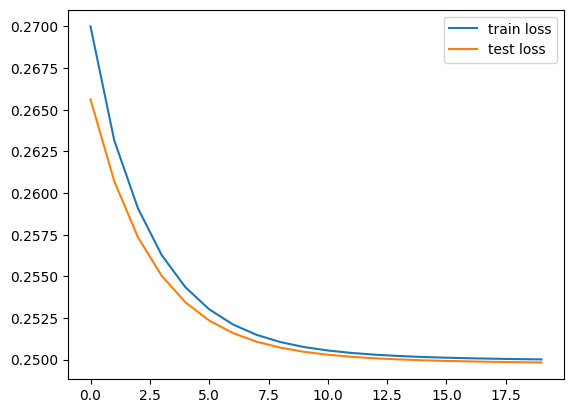

In [31]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [48]:
sample = X_test[y_test == 0][:100]
with torch.no_grad():
    pred, _, _ = model(torch.from_numpy(sample).to(torch.float32).to(device))
pred = pred.cpu()
pred.shape

torch.Size([100, 5, 52])

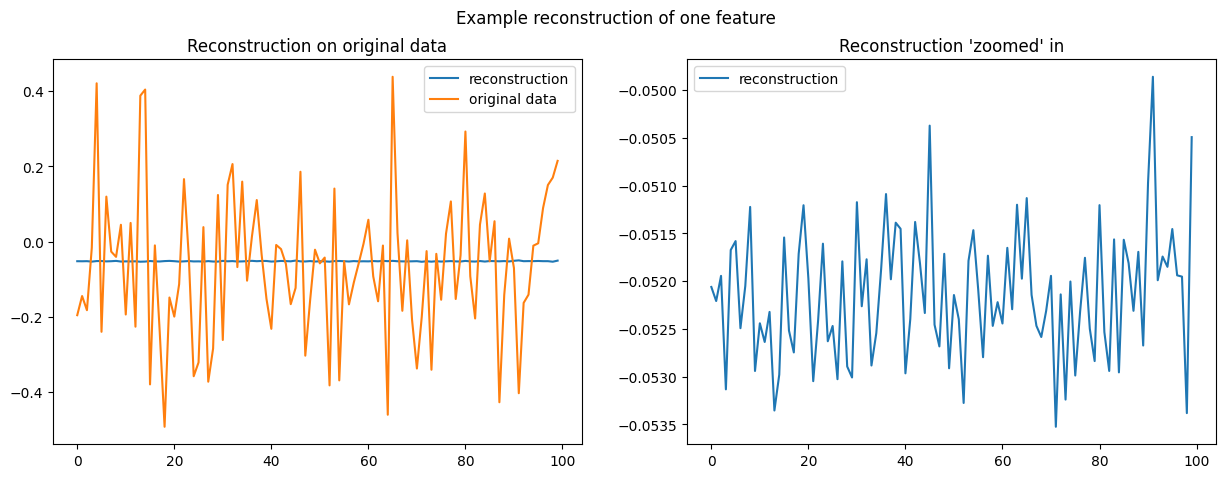

In [61]:
fix, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(pred[:, 0, 0], label="reconstruction")
ax[0].plot(sample[:, 0, 0], label="original data")
ax[0].title.set_text("Reconstruction on original data")
ax[0].legend()
ax[1].plot(pred[:, 0, 0], label="reconstruction")
ax[1].title.set_text("Reconstruction 'zoomed' in")
ax[1].legend()
plt.suptitle("Example reconstruction of one feature")
plt.show()

In [81]:
max_reconstruction_error = 0.0

r_losses = []

with tqdm(total=X_train[y_train == 0].shape[0]) as pbar:
    for x in X_train[y_train == 0]:
        x = torch.from_numpy(x).to(torch.float32).to(device)
        x = x[None, :, :] # add 1 as batch dimension
        with torch.no_grad():
            pred, _, _ = model(x)
        error = F.mse_loss(pred, x).detach().item()
        if error > max_reconstruction_error:
            max_reconstruction_error = error
        
        r_losses.append(error)
        
        pbar.update(1)
        
print(f"Max reconstruction error: {np.mean(r_losses)}")

100%|█████████████████████████████████████████████████████████████████████████| 511426/511426 [20:51<00:00, 408.74it/s]

Max reconstruction error: 0.24958605046530843


In [92]:
r_loss = np.mean(r_losses)

In [101]:
y_hat = []
y_true = []

with tqdm(total=X_val.shape[0]) as pbar:
    for x, y in zip(X_val, y_val):
        with torch.no_grad():
            x = torch.from_numpy(x).to(torch.float32).to(device)
            x = x[None, :, :]
            pred, _, _ = model(x)
        error = F.mse_loss(pred, x).detach().item()
        
        y_true.append(1 if y > 0 else 0)
        y_hat.append(1 if error > r_loss else 0)
        
        pbar.update(1)

accuracy_score(y_true, y_hat)

100%|█████████████████████████████████████████████████████████████████████| 1970999/1970999 [1:56:09<00:00, 282.81it/s]


0.7672210894069454

In [102]:
results = pd.DataFrame({"y_pred": y_hat, "y_true": y_true})
results.to_csv("evaluation_results.csv")

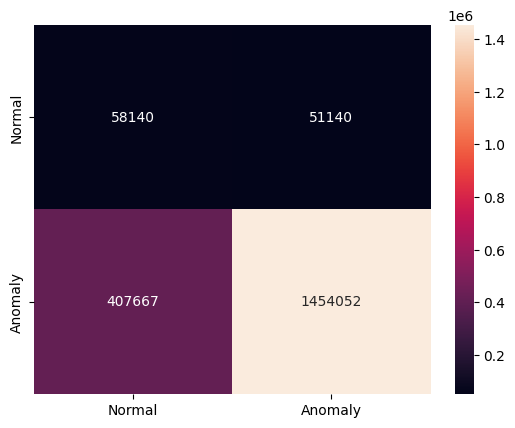

In [103]:
cm = confusion_matrix(y_true, y_hat)
df_cm = pd.DataFrame(cm, index=["Normal", "Anomaly"], columns=["Normal", "Anomaly"])
sn.heatmap(df_cm, annot=True, fmt=".0f")
plt.show()